In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.options.mode.chained_assignment = None

import xgboost as xgb
root='C:/Users/luthf/Documents/DS/BasketAnalysis/'

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

In [2]:
df=pd.read_pickle(root+'datafinal.pkl')

In [3]:
df.head()

,user_id,product_id,avg_add_to_cart_by_user,avg_day_since_prior_order,user_total_order_product,user_total_reorder_product,user_percentage_reorder_product,last_order_in,is_reorder_3,is_reorder_2,...,user_total_reorder,user_overal_reorder,avg_order_size,mean_reorder_size,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,1.400000,17.600000,10.0,9.0,0.900000,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
1,1,10258,3.333333,19.555555,9.0,8.0,0.888889,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
2,1,10326,5.000000,28.000000,1.0,0.0,0.000000,5.0,0.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
3,1,12427,3.300000,17.600000,10.0,9.0,0.900000,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
4,1,13032,6.333333,21.666666,3.0,2.0,0.666667,10.0,1.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667


In [4]:
def reduce_memory(df):
    
    """
    This function reduce the dataframe memory usage by converting it's type for easier handling.
    
    Parameters: Dataframe
    Return: Dataframe
    """
    
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        if df[col].dtypes in ["float64", "float32"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    
    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    return df

In [5]:
df = reduce_memory(df)

Memory usage of properties dataframe is : 4041.0332679748535  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1188.063780784607  MB
This is  29.4 % of the initial size


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8474661 entries, 0 to 8474660
Data columns (total 65 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   user_id                          int32  
 1   product_id                       uint64 
 2   avg_add_to_cart_by_user          float16
 3   avg_day_since_prior_order        float16
 4   user_total_order_product         float16
 5   user_total_reorder_product       float16
 6   user_percentage_reorder_product  float16
 7   last_order_in                    float16
 8   is_reorder_3                     float16
 9   is_reorder_2                     float16
 10  is_reorder_1                     float16
 11  order_number                     float16
 12  order_dow                        float16
 13  order_hour_of_day                float16
 14  days_since_prior_order           float16
 15  reordered                        float16
 16  mean_add_to_cart                 float16
 17  total_or

In [8]:
df.last_order_in

0          10.0
1          10.0
2           5.0
3          10.0
4          10.0
           ... 
8474656    12.0
8474657     7.0
8474658    11.0
8474659     7.0
8474660    12.0
Name: last_order_in, Length: 8474661, dtype: float16

In [9]:
df['order_diff']=df.order_number-df.last_order_in

In [11]:
df.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [12]:
df.head()

,avg_add_to_cart_by_user,avg_day_since_prior_order,user_total_order_product,user_total_reorder_product,user_percentage_reorder_product,last_order_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,...,user_overal_reorder,avg_order_size,mean_reorder_size,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,1.400391,17.593750,10.0,9.0,0.899902,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0
1,3.333984,19.562500,9.0,8.0,0.888672,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0
2,5.000000,28.000000,1.0,0.0,0.000000,5.0,0.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,6.0
3,3.300781,17.593750,10.0,9.0,0.899902,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0
4,6.332031,21.671875,3.0,2.0,0.666504,10.0,1.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0


In [18]:
label='reordered'
parameter=df.columns.drop('reordered')

In [21]:
X=df[parameter]
y=df[label]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.30)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5932262, 63) (5932262,)
(2542399, 63) (2542399,)


In [23]:
y_train.value_counts()

0.0    5352085
1.0     580177
Name: reordered, dtype: int64

In [24]:
y_test.value_counts()

0.0    2293752
1.0     248647
Name: reordered, dtype: int64

In [32]:
np.ceil(y_train.value_counts()[0]/y_train.value_counts()[1])

10.0

In [33]:
model_train=xgb.DMatrix(X_train,label=y_train)
model_test=xgb.DMatrix(X_test,label=y_test)


In [34]:
xgb_params = {
    "objective"        :"reg:logistic",
    "eval_metric"      :"logloss",
    "eta"              :0.1,
    "max_depth"        :6,
    "min_child_weight" :10,
    "gamma"            :0.70,
    "subsample"        :0.76,
    "colsample_bytree" :0.95,
    "alpha"            :2e-05,
    "scale_pos_weight" :10,
    "lambda"           :10
}

In [35]:
watchlist= [(model_train, "train")]
model = xgb.train(params=xgb_params, dtrain=model_train, num_boost_round = 80, evals = watchlist, verbose_eval = 10)

[0]	train-logloss:0.66497
[10]	train-logloss:0.55460
[20]	train-logloss:0.53378
[30]	train-logloss:0.52782
[40]	train-logloss:0.52534
[50]	train-logloss:0.52412
[60]	train-logloss:0.52303
[70]	train-logloss:0.52235
[79]	train-logloss:0.52168


In [36]:
probability = model.predict(model_test)


In [37]:
predictions = [1 if i > 0.5 else 0 for i in probability]


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.97      0.74      0.84   2293752
         1.0       0.24      0.77      0.37    248647

    accuracy                           0.74   2542399
   macro avg       0.60      0.75      0.60   2542399
weighted avg       0.90      0.74      0.79   2542399

Accuracy   Score :  0.7422434480189773
F1 Score:  0.3681616407819785
Area under curve :  0.8342115090196702 



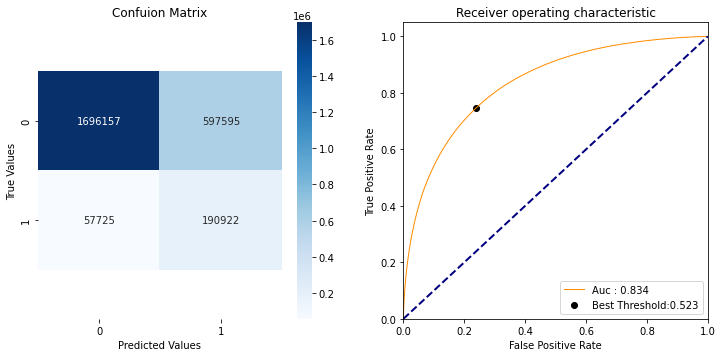

In [38]:
print ("\n Classification report : \n",classification_report(y_test, predictions))
print ("Accuracy   Score : ",accuracy_score(y_test, predictions))

#confusion matrix
conf_matrix = confusion_matrix(y_test,predictions)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

#f1-score
f1 = f1_score(y_test, predictions)
print("F1 Score: ", f1)

#roc_auc_score
model_roc_auc = roc_auc_score(y_test,probability) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probability)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix],3)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

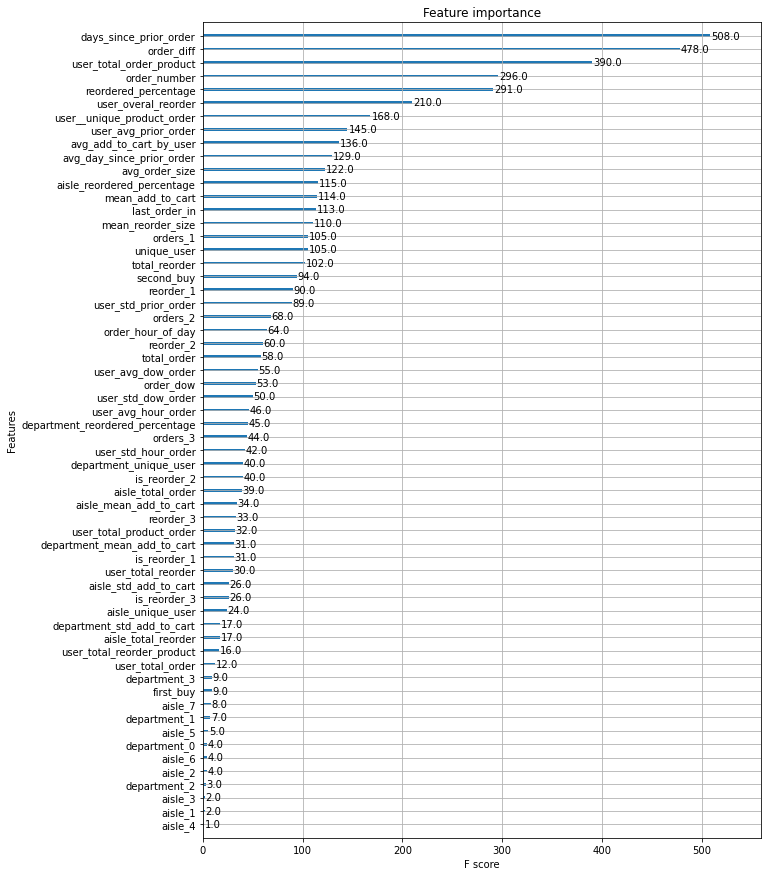

In [39]:
fig, ax = plt.subplots(figsize = (10,15))
xgb.plot_importance(model, ax = ax)
fig.savefig('XGBoost Feature Importance Plot.png')